In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_curve, auc,
    f1_score, roc_auc_score, confusion_matrix, classification_report)

from medmnist import PathMNIST

import warnings
warnings.filterwarnings("ignore")

### Model Definition

In [17]:
model_path = "./modele/base_model_keras.h5"
model = tf.keras.models.load_model(model_path)

### Data preparation

In [6]:
test_dataset = PathMNIST(split="test",  size=64)

In [4]:
def prepare_data_with_augmentation(dataset, num_classes=9, augment=True):

    images = dataset.imgs / 255.0  # [0, 1]
    labels = to_categorical(dataset.labels, num_classes=num_classes)

    if augment:
        # Konfiguracja augmentacji
        datagen = ImageDataGenerator(
            rotation_range=15,           
            width_shift_range=0.1,       
            height_shift_range=0.1,     
            shear_range=0.1,            
            zoom_range=0.1,            
            horizontal_flip=True,    
            fill_mode='nearest'
        )

        datagen.fit(images)
        return datagen, images, labels
    else:
        return None, images, labels

### Prediction

In [10]:
datagen, X_test, labels = prepare_data_with_augmentation(test_dataset, augment=False)
predictions = model.predict(X_test)

225/225 [==============================] - 5s 20ms/step


### Converting keys to numbers

In [11]:
y_test = labels.argmax(axis=1)

### Calculating class predictions

In [12]:
y_pred = predictions.argmax(axis=1)

### Calculation of classification evaluation metrics

In [14]:
y_test_binarized = labels  # Etykiety w formacie one-hot
auc_score = roc_auc_score(y_test_binarized, predictions, multi_class="ovr")
class_labels = test_dataset.info['label']

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Area Under Curve (AUC): {auc_score:.4f}")

Accuracy: 0.8875
Precision: 0.8847
Recall: 0.8875
F1 Score: 0.8846
Area Under Curve (AUC): 0.9875


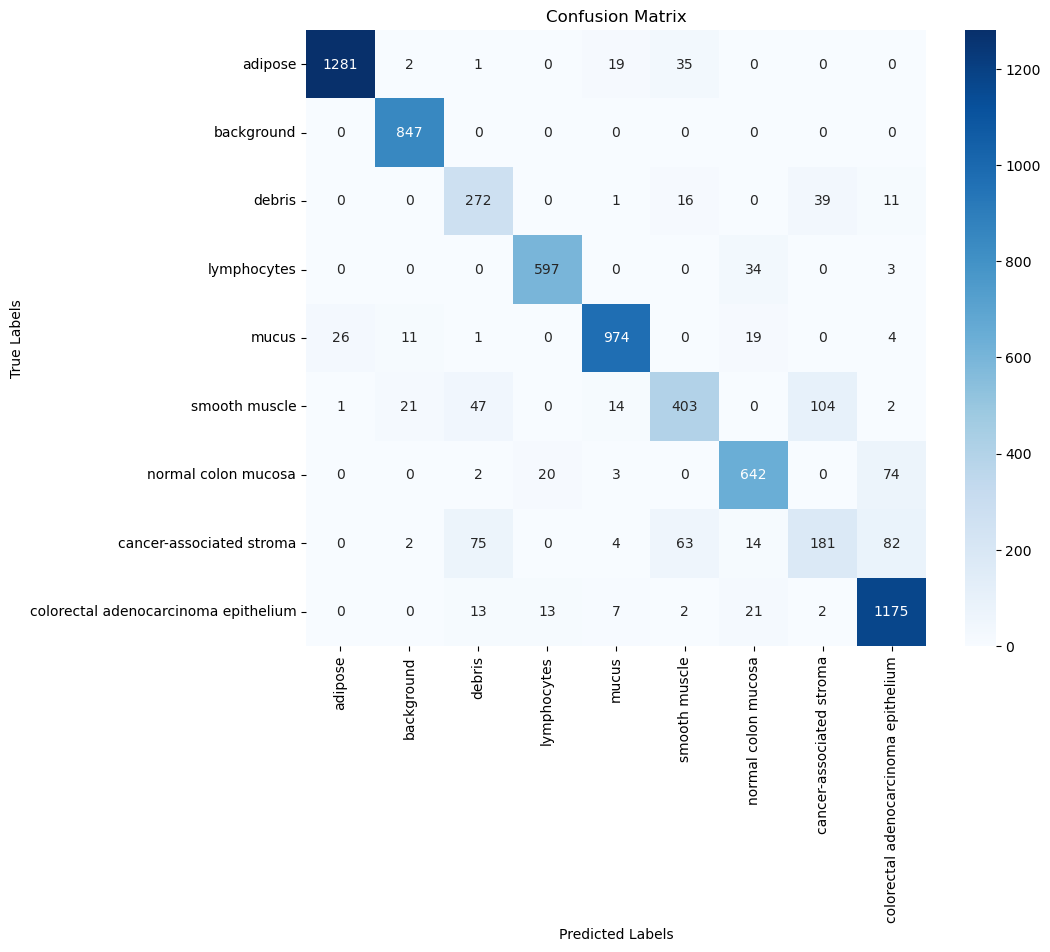

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

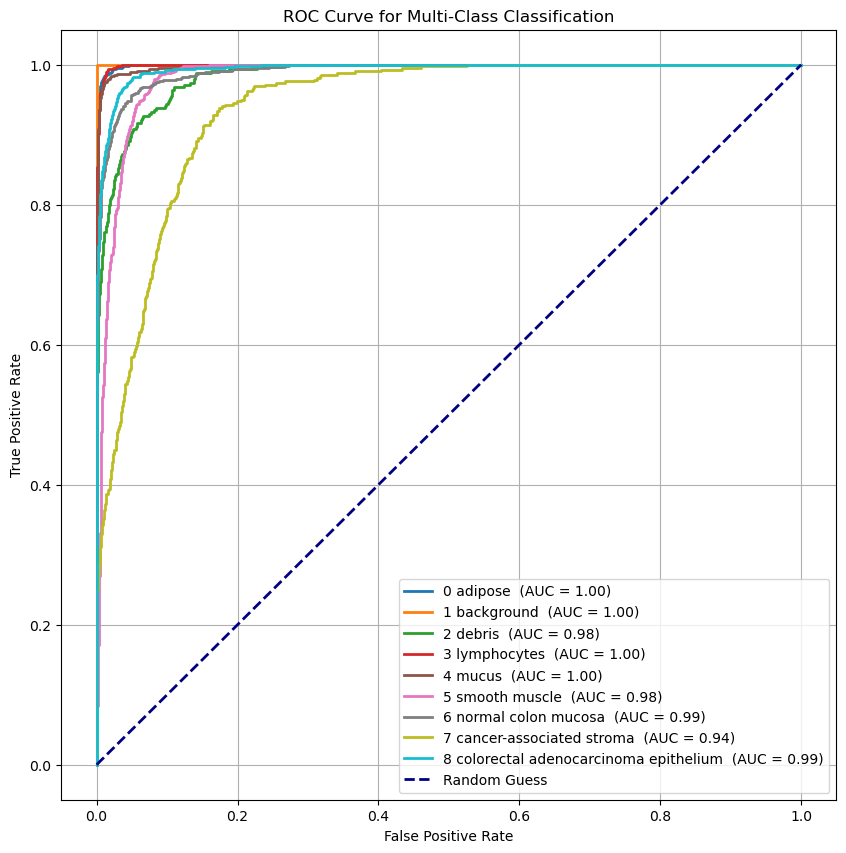

In [16]:
n_classes = predictions.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
colors = plt.cm.get_cmap("tab10", n_classes)  

class_labels = test_dataset.info['label']

for i in range(n_classes):
    nm = class_labels[str(i)]
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f"{i} {nm}  (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2, label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.grid()
plt.show()